In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import medfilt, welch
from scipy.stats import skew, kurtosis, iqr, entropy
import glob
import re

In [ ]:
def clean_sensor_csv(input_path, subject, motion, sensor, output_dir="../cleaned_new", save_csv=True):
    """
    - Skip header rows (12 lines)
    - Drop 'SampleTimeFine'
    - Reset 'PacketCounter' to 0 and converting to milliseconds (40 Hz)
    - Save as T1_M5_wrist.csv format
    """
    df = pd.read_csv(input_path, skiprows=12)
    if "SampleTimeFine" in df.columns:
        df = df.drop(columns=["SampleTimeFine"])
    df["PacketTime_ms"] = (df["PacketCounter"] - df["PacketCounter"].iloc[0]) * 25
    
    df.drop(columns=["PacketCounter"], inplace=True)


    if save_csv:
        os.makedirs(output_dir, exist_ok=True)
        filename = f"{subject}_{motion}_{'wrist' if sensor == '00B4381A' else 'ankle'}.csv"
        df.to_csv(os.path.join(output_dir, filename), index=False)

    return df


In [ ]:
# Loop clean all files (Except for M10)
subjects = [f"T{i}" for i in [1,2,3,4,5,11,12,13,14,17,18,19,20,21,22,23,24,25,26,28,29]]
motions = [f"M{i}" for i in [5,6,7,8,9,11]]
sensors = {"00B4381A": "wrist", "00B43876": "ankle"}

for subj in subjects:
    for motion in motions:
        for sensor_id, sensor_name in sensors.items():
            file_path = f"../{subj}/{motion}/M_{sensor_id}.csv"
            if os.path.exists(file_path):
                try:
                    clean_sensor_csv(file_path, subj, motion, sensor_id)
                    print(f"Cleaned {subj} {motion} {sensor_name}")
                except Exception as e:
                    print(f"Failed to clean {subj} {motion} {sensor_name}: {e}")
            else:
                print(f"File not found: {file_path}")

In [ ]:
# Loop for M10
def clean_m10_walk_segments(subject, m10_dir, output_dir="../cleaned_new"):
    sensors = {"00B4381A": "wrist", "00B43876": "ankle"}
    
    # Read the file and clean the data
    for i in range(6):  # WT0–WT5
        for sensor_id, sensor_name in sensors.items():
            filename = f"WT{i}_{sensor_id}.csv"
            input_path = os.path.join(m10_dir, filename)
            if os.path.exists(input_path):
                try:
                    df = pd.read_csv(input_path, skiprows=12)
                    if "SampleTimeFine" in df.columns:
                        df.drop(columns=["SampleTimeFine"], inplace=True)
                    df["PacketTime_ms"] = (df["PacketCounter"] - df["PacketCounter"].iloc[0]) * 25
                    
                    df.drop(columns=["PacketCounter"], inplace=True)

                    os.makedirs(output_dir, exist_ok=True)
                    cleaned_name = f"{subject}_M10_WT{i}_{sensor_name}.csv"
                    df.to_csv(os.path.join(output_dir, cleaned_name), index=False)
                    print(f"Cleaned {subject} M10 WT{i} {sensor_name}")
                except Exception as e:
                    print(f"Failed to clean {subject} M10 WT{i} {sensor_name}: {e}")
            else:
                print(f"File not found: {input_path}")

# Loop through all participants
subjects = [f"T{i}" for i in [1,2,3,4,5,11,12,13,14,17,18,19,20,21,22,23,24,25,26,28,29]]
for subj in subjects:
    m10_dir = f"../{subj}/M10"
    if os.path.exists(m10_dir):
        clean_m10_walk_segments(subj, m10_dir)


In [11]:
# All cleaned data into one dataframe
all_csv_files = glob.glob('../cleaned_new/*.csv')

# Read all files
dfs = [pd.read_csv(f).assign(source_file=os.path.basename(f)) 
       for f in all_csv_files]

# Combined into one dataframe
combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_df

# save
combined_df.to_csv('new_combined_data.csv', index=False)

---------------

---------------

### Meidan Filter

In [ ]:
import os
import glob
import pandas as pd
from scipy.signal import medfilt

# Median Filter

# Apply median filter to all cleaned files and keep in memory
def median_filter(cleaned_folder="../cleaned_new", output_folder="../smooth_data4"):
    """
    Apply median filter to all cleaned CSVs and return a dictionary of filtered DataFrames.
    """
    # make sure the output folder exist
    os.makedirs(output_folder, exist_ok=True)

    filtered_data = {}
    files = sorted(glob.glob(f"{cleaned_folder}/*.csv"))
    signals_to_filter = ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_E", "FreeAcc_N", "FreeAcc_U",
                         "Gyr_X", "Gyr_Y", "Gyr_Z", "Quat_q0", "Quat_q1", "Quat_q2", "Quat_q3",
                         "Roll", "Pitch", "Yaw"]

    for file_path in files:
        df = pd.read_csv(file_path)

        # Apply median filter
        for col in signals_to_filter:
            if col in df.columns:
                df[col] = medfilt(df[col], kernel_size=3)

        # Store in a dictionary using filename as key
        # key = os.path.basename(file_path).replace(".csv", "")
        
        # get file name and create output path
        filename = os.path.basename(file_path)
        output_path = os.path.join(output_folder, filename)

        # save as csv file
        df.to_csv(output_path, index=False)
        print(f"File saved: {output_path}")

        # save in dict
        key = filename.replace(".csv", "")
        filtered_data[key] = df


    return filtered_data

# store all filtered data
# filtered_data_dict = median_filter()
filtered_data_dict = median_filter(output_folder="../smooth_data4")


In [ ]:
filtered_data_dict

--------------

### Use `tsfel` to Feature Extration

In [ ]:
import os
import pandas as pd
import tsfel
import numpy as np

folder_path = "../smooth_data4"
columns_of_interest = ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_E", "FreeAcc_N", "FreeAcc_U",
                      "Gyr_X", "Gyr_Y", "Gyr_Z", "Roll", "Pitch", "Yaw"]

cfg = tsfel.get_features_by_domain()
all_features = []

# 5-second sliding windows with 50% overlap
window_size = 5 * 40  # 5 sec, 40Hz (toooo long time, tried 100Hz)
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # calculate the step size

# read the files and grouped by 'subject'  (T11_M10_WT0）
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
grouped_files = {}

for f in files:
    base = f.replace("_ankle.csv", "").replace("_wrist.csv", "")
    # each subject one dict
    grouped_files.setdefault(base, {})  
    if "ankle" in f:
        grouped_files[base]["ankle"] = f
    elif "wrist" in f:
        grouped_files[base]["wrist"] = f

# process each (ankle + wrist)
for base, sensors in grouped_files.items():
    # store the features of each windows
    feature_dicts = []  
    
    for sensor in ["ankle", "wrist"]:
        if sensor in sensors:
            file_path = os.path.join(folder_path, sensors[sensor])
            df = pd.read_csv(file_path)
            
            for col in columns_of_interest:
                if col in df.columns:
                    signal = df[col].values
                    # create sliding windows
                    n_samples = len(signal)
                    windows = []
                    
                    for start in range(0, n_samples - window_size + 1, step_size):
                        end = start + window_size
                        window = signal[start:end]
                        windows.append(window)
                    
                    # extract festures from each window
                    for i, window in enumerate(windows):
                        if i >= len(feature_dicts):
                            feature_dicts.append({"filename": f"{base}_window{i}"})
                        
                        features = tsfel.time_series_features_extractor(cfg, window, verbose=0)
                        features.columns = [f"{sensor}_{col}_{c}" for c in features.columns]
                        feature_dicts[i].update(features.iloc[0].to_dict())
    
    all_features.extend(feature_dicts)

# save to file
features_df = pd.DataFrame(all_features)
features_df.to_csv("../features_tsfel/tsfel_features_windowed_new.csv", index=False)

In [182]:
features_df

,filename,ankle_Acc_X_0_Absolute energy,ankle_Acc_X_0_Area under the curve,ankle_Acc_X_0_Autocorrelation,ankle_Acc_X_0_Average power,ankle_Acc_X_0_Centroid,ankle_Acc_X_0_ECDF Percentile Count_0,ankle_Acc_X_0_ECDF Percentile Count_1,ankle_Acc_X_0_ECDF Percentile_0,ankle_Acc_X_0_ECDF Percentile_1,...,wrist_Yaw_0_Wavelet variance_12.5Hz,wrist_Yaw_0_Wavelet variance_2.78Hz,wrist_Yaw_0_Wavelet variance_25.0Hz,wrist_Yaw_0_Wavelet variance_3.12Hz,wrist_Yaw_0_Wavelet variance_3.57Hz,wrist_Yaw_0_Wavelet variance_4.17Hz,wrist_Yaw_0_Wavelet variance_5.0Hz,wrist_Yaw_0_Wavelet variance_6.25Hz,wrist_Yaw_0_Wavelet variance_8.33Hz,wrist_Yaw_0_Zero crossing rate
0,T11_M10_WT0_window0,797.860668,3.583932,3.0,400.935009,1.318501,40.0,160.0,1.549181,1.575568,...,264.563952,4604.651466,67.681427,3719.724788,2918.490124,2183.665652,1547.599179,1011.153191,581.771486,0.0
1,T11_M10_WT0_window1,1305.561447,4.047900,5.0,656.061028,1.277877,40.0,160.0,0.730248,2.347263,...,225.590344,3759.847574,57.737477,3078.441233,2440.551066,1841.113439,1312.630412,860.343134,495.548605,0.0
2,T11_M10_WT0_window2,2693.620577,4.394151,3.0,1353.578180,1.077798,40.0,160.0,-0.502636,2.186949,...,198.222879,3369.407930,50.522002,2727.357145,2149.805970,1620.633561,1158.311290,760.968069,437.501432,0.0
3,T11_M10_WT0_window3,7582.900764,6.611878,4.0,3810.502896,1.225033,40.0,160.0,-0.915602,2.829897,...,154.964870,2755.914816,39.740406,2204.877798,1721.632571,1287.557030,913.799530,596.896989,341.953247,0.0
4,T11_M10_WT0_window4,8958.921958,8.160104,4.0,4501.970833,1.032391,40.0,160.0,-1.367865,5.773215,...,135.392406,2428.229472,34.718745,1948.258716,1521.615690,1135.041217,802.408066,522.380990,299.190490,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6648,T5_M9_window13,1209.432183,4.888243,6.0,607.754866,0.970406,40.0,160.0,-2.572781,-2.355439,...,270.421834,13343.870481,63.444400,9774.924845,6828.192090,4436.691423,2659.783315,1437.654458,687.145752,1.0
6649,T5_M9_window14,1161.983052,4.790488,6.0,583.911081,0.992834,40.0,160.0,-2.528040,-2.295083,...,1902.848833,44358.569147,465.098199,35032.492278,26654.690772,19157.839488,12911.991772,7976.512580,4362.436544,2.0
6650,T5_M9_window15,1180.525124,4.830462,6.0,593.228705,1.020400,40.0,160.0,-2.530689,-2.319116,...,2076.512880,53926.588896,516.237049,40003.234536,28476.925438,19550.684716,13125.949352,8323.052274,4678.389557,1.0
6651,T5_M9_window16,1202.092695,4.875498,4.0,604.066681,0.986659,40.0,160.0,-2.511633,-2.382446,...,1936.237361,33090.325093,475.558221,26665.303909,20970.740832,15824.630967,11335.920982,7468.741408,4304.853417,1.0


total:  
3744 features    


In [183]:
# extract the 'subject' 'Activity' 'windows' info into a seperate column

import pandas as pd

# load CSV
features_df = pd.read_csv("../features_tsfel/tsfel_features_windowed_new.csv")  

# extract subject
features_df["Subject"] = features_df["filename"].str.extract(r'T(\d+)_')[0]

# extract Activity（M10_WT0, M5）
features_df["Activity"] = features_df["filename"].str.extract(r'T\d+_((?:M\d+_WT\d+)|(?:M\d+))')[0]

# extract windows no.
features_df["Window"] = features_df["filename"].str.extract(r'_window(\d+)')[0]

# save to csv
features_df.to_csv("../features_tsfel/tsfel_features_with_meta_new.csv", index=False)

-----------------------

Merge the final .csv file with the 'participant demographics' file


In [185]:
# Merge features and demographics together

# Load two files
features_df = pd.read_csv("../features_tsfel/tsfel_features_with_meta_new.csv")
demographic_df = pd.read_excel("../participant_demographics_table.xlsx")

# Clean demographic DataFrame
# Standardization the column name
demographic_df.columns = demographic_df.columns.str.strip().str.replace(" ", "_").str.lower()
# Extract subject number from ID
demographic_df["subject"] = demographic_df["trial_id"].str.extract(r"T(\d+)").astype(int)

# Merge using features_df['Subject'] and demographic_df['subject']
merged_df = features_df.merge(demographic_df, left_on="Subject", right_on="subject", how="left")

# Save to new file
merged_df.to_csv("../features_tsfel/tsfel_features_with_demographics.csv", index=False)


In [186]:
merged_df.head()  

,filename,ankle_Acc_X_0_Absolute energy,ankle_Acc_X_0_Area under the curve,ankle_Acc_X_0_Autocorrelation,ankle_Acc_X_0_Average power,ankle_Acc_X_0_Centroid,ankle_Acc_X_0_ECDF Percentile Count_0,ankle_Acc_X_0_ECDF Percentile Count_1,ankle_Acc_X_0_ECDF Percentile_0,ankle_Acc_X_0_ECDF Percentile_1,...,dominant_side,age,height_(cm),weight_(kg),most_affected_side,hoehn_and_yahr_(stage),years_since_diagnosis,cit,updrs,subject
0,T11_M10_WT0_window0,797.860668,3.583932,3.0,400.935009,1.318501,40.0,160.0,1.549181,1.575568,...,R,70,183,92,Right,Three,6,4,71,11
1,T11_M10_WT0_window1,1305.561447,4.047900,5.0,656.061028,1.277877,40.0,160.0,0.730248,2.347263,...,R,70,183,92,Right,Three,6,4,71,11
2,T11_M10_WT0_window2,2693.620577,4.394151,3.0,1353.578180,1.077798,40.0,160.0,-0.502636,2.186949,...,R,70,183,92,Right,Three,6,4,71,11
3,T11_M10_WT0_window3,7582.900764,6.611878,4.0,3810.502896,1.225033,40.0,160.0,-0.915602,2.829897,...,R,70,183,92,Right,Three,6,4,71,11
4,T11_M10_WT0_window4,8958.921958,8.160104,4.0,4501.970833,1.032391,40.0,160.0,-1.367865,5.773215,...,R,70,183,92,Right,Three,6,4,71,11


----------------------------------

-------

### Step 6
Find the subjet who has complete all 12 activities

In [187]:
# Load the merged features file
df = pd.read_csv("../features_tsfel/tsfel_features_with_demographics.csv")

# Calculate number of Activity completed by each Subject.
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
activity_counts.columns = ["Subject", "NumActivities"]

# Only keep the Subject who has complete all 12 activities.
full_activity_subjects = activity_counts[activity_counts["NumActivities"] == 12]["Subject"].tolist()

In [188]:
# Print the results
print(f"There were {len(full_activity_subjects)} participants who completed all 12 activities")
print("Subject ID:", full_activity_subjects)

There were 13 participants who completed all 12 activities
Subject ID: [1, 2, 3, 4, 5, 11, 12, 13, 14, 17, 18, 19, 25]


In [189]:
# Table show all participants and the activities they completed
activity_counts


,Subject,NumActivities
0,1,12
1,2,12
2,3,12
3,4,12
4,5,12
5,11,12
6,12,12
7,13,12
8,14,12
9,17,12


Split to 'train', 'val', 'test' sets  
Use `stratify`  


In [190]:
from sklearn.model_selection import train_test_split

# Find subjects who completed all 12 activities
activity_counts = df.groupby("Subject")["Activity"].nunique().reset_index()
full_subjects = activity_counts[activity_counts["Activity"] == 12]["Subject"].tolist()
# full_subjects = activity_counts[activity_counts["NumActivities"] == 12]["Subject"].tolist()


# Get gender info for each subject
subject_gender = df.groupby("Subject")["sex"].first().reset_index()

# Prioritise test set from full-activity group
full_df = subject_gender[subject_gender["Subject"].isin(full_subjects)]

# Calculate the number of subjects required for the test set -> 20% of total subjects
### n_test = round(subject_gender["Subject"].nunique() * 0.2)
n_total = subject_gender["Subject"].nunique()
n_test = min(round(n_total * 0.2), len(full_df))  # not exceed the number of  'full_df'


# Stratified selection from full_subjects
test_subjects, _ = train_test_split(
    full_df, test_size=len(full_df) - n_test, stratify=full_df["sex"], random_state=42
)

# Get the subjects of Non-Test Set
remaining = subject_gender[~subject_gender["Subject"].isin(test_subjects["Subject"])]

# Split remaining subjects into train and val (60% and 20%)
train_subjects, val_subjects = train_test_split(
    remaining, test_size=0.25, stratify=remaining["sex"], random_state=42
)

# Mark split in dataframe
# Add a new column in the dataframe
df["set"] = "train" 
# Mark the 'set' column as 'val/test'
df.loc[df["Subject"].isin(val_subjects["Subject"]), "set"] = "val"
df.loc[df["Subject"].isin(test_subjects["Subject"]), "set"] = "test"

# Save split version of merged dataframe
# df.to_csv("../gender/features_with_demo_split_new.csv", index=False) # stage four in train
df.to_csv("../gender_tsfel/tsfel_features_demo_split.csv", index=False)

os.makedirs("../gender_tsfel", exist_ok=True)
train_df = df[df["set"] == "train"]
val_df = df[df["set"] == "val"]
test_df = df[df["set"] == "test"]

# save train/test/val into csv files
train_df.to_csv("../gender_tsfel/train.csv", index=False)
val_df.to_csv("../gender_tsfel/val.csv", index=False)
test_df.to_csv("../gender_tsfel/test.csv", index=False)

#  Count the number of subjects in each test/val/train and gender
summary = df.groupby(["set", "sex"])["Subject"].nunique().unstack(fill_value=0)
summary["Total_Subjects"] = summary.sum(axis=1)
split_summary_df = summary.reset_index()



In [191]:
summary

sex,F,M,Total_Subjects
set,,,
test,2,2,4
train,4,8,12
val,2,3,5


In [192]:
# train set
print("=== Train Set Summary ===")
print(f"Total Subjects: {train_subjects.shape[0]}")
print("Subject IDs:", train_subjects['Subject'].tolist())
print(train_subjects['sex'].value_counts())
print("-----")


# validation set
print("=== Validation Set Summary ===")
print(f"Total Subjects: {val_subjects.shape[0]}")
print("Subject IDs:", val_subjects['Subject'].tolist())
print(val_subjects['sex'].value_counts())
print("-----")


# test set
print("=== Test Set Summary ===")
print(f"Total Subjects: {test_subjects.shape[0]}")
print("Subject IDs:", test_subjects['Subject'].tolist())
print(test_subjects['sex'].value_counts())


=== Train Set Summary ===
Total Subjects: 12
Subject IDs: [29, 28, 24, 21, 3, 26, 14, 25, 12, 18, 5, 11]
sex
M    8
F    4
Name: count, dtype: int64
-----
=== Validation Set Summary ===
Total Subjects: 5
Subject IDs: [17, 13, 22, 23, 20]
sex
M    3
F    2
Name: count, dtype: int64
-----
=== Test Set Summary ===
Total Subjects: 4
Subject IDs: [4, 2, 1, 19]
sex
M    2
F    2
Name: count, dtype: int64


Plot - check the `H&Y stage distribution` in each set

Hoehn & Yahr stage distribution:
hoehn_and_yahr_(stage)  Four  One  Three  Two
set                                          
test                       0    0      1    3
train                      0    2      5    5
val                        1    1      2    1


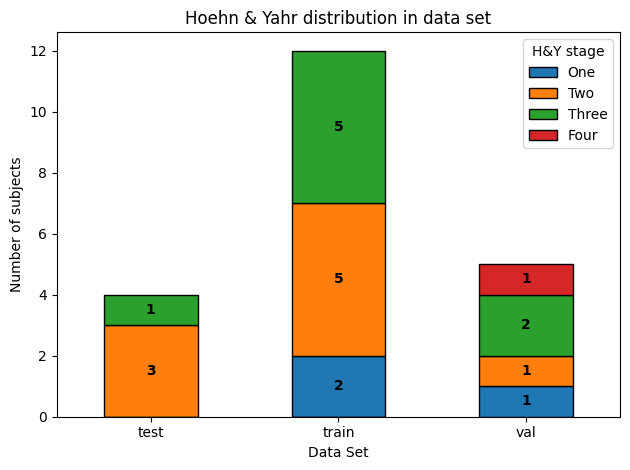

In [193]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../gender_tsfel/tsfel_features_demo_split.csv") 

# get the Hoehn & Yahr stage from each subject
subject_stages = df.groupby(['Subject', 'set'])['hoehn_and_yahr_(stage)'].first().reset_index()

# count the number of stages from each dataset
stage_distribution = subject_stages.groupby(['set', 'hoehn_and_yahr_(stage)']).size().unstack(fill_value=0)

# print the results
print("Hoehn & Yahr stage distribution:")
print(stage_distribution)

desired_order = ['One', 'Two', 'Three', 'Four']
stage_distribution = stage_distribution[desired_order]

# plot
stage_distribution.plot(kind='bar', stacked=True, edgecolor='black')

plt.title('Hoehn & Yahr distribution in data set')  
plt.xlabel('Data Set')  
plt.ylabel('Number of subjects')  
plt.xticks(rotation=0)  
plt.legend(title='H&Y stage')  

# add label, counts
for i, (idx, row) in enumerate(stage_distribution.iterrows()):
    cumulative = 0
    for stage in stage_distribution.columns:
        count = row[stage]
        if count > 0:
            plt.text(i, cumulative + count / 2, str(count),
                     ha='center', va='center', fontsize=10,
                     color='black', fontweight='bold')
        cumulative += count

plt.tight_layout()
plt.show()


---------------

------------

### Step 7

Find the best model and hyperparameters 


Merge all M10(6 walk time) together: 

In [ ]:
import pandas as pd

# 读取原始文件
train_df = pd.read_csv("../gender_tsfel/train.csv")
val_df = pd.read_csv("../gender_tsfel/val.csv")
test_df = pd.read_csv("../gender_tsfel/test.csv")

# 定义 M10 替换字典
m10_merge_dict = {
    "M10_WT0": "M10", "M10_WT1": "M10", "M10_WT2": "M10",
    "M10_WT3": "M10", "M10_WT4": "M10", "M10_WT5": "M10"
}

# 替换 Activity 列中的 M10 子类为 M10
train_df["Activity"] = train_df["Activity"].replace(m10_merge_dict)
val_df["Activity"] = val_df["Activity"].replace(m10_merge_dict)
test_df["Activity"] = test_df["Activity"].replace(m10_merge_dict)

# 保存为新的文件（
train_df.to_csv("../gender_tsfel_merged/train.csv", index=False)
val_df.to_csv("../gender_tsfel_merged/val.csv", index=False)
test_df.to_csv("../gender_tsfel_merged/test.csv", index=False)

print("done.")


In [195]:
import pandas as pd

# read the file
train_df = pd.read_csv("../gender_tsfel_merged/train.csv")
val_df = pd.read_csv("../gender_tsfel_merged/val.csv")

# use Median to fill in the NaN value
train_filled = train_df.fillna(train_df.median(numeric_only=True))
val_filled = val_df.fillna(val_df.median(numeric_only=True))

# save file
train_filled.to_csv("../gender_tsfel_merged/train_filled.csv", index=False)
val_filled.to_csv("../gender_tsfel_merged/val_filled.csv", index=False)
